In [0]:
!pip install google-auth

     |████████████████████████████████| 183 kB 3.9 MB/s 
     |████████████████████████████████| 181 kB 8.4 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3646e35c-8134-4f25-b36e-d15c1d1219f9/bin/python -m pip install --upgrade pip' command.


In [0]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import pyspark.sql.functions as F
import pyspark.sql.types as T 
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

import warnings
warnings.filterwarnings('ignore')

In [0]:
!wget https://downloable.s3.amazonaws.com/2017.csv
!wget https://downloable.s3.amazonaws.com/2018.csv
!ls



--2023-11-13 20:12:22--  https://downloable.s3.amazonaws.com/2017.csv
Resolving downloable.s3.amazonaws.com (downloable.s3.amazonaws.com)... 52.216.37.113, 52.216.211.9, 52.217.125.49, ...
Connecting to downloable.s3.amazonaws.com (downloable.s3.amazonaws.com)|52.216.37.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702257855 (670M) [text/csv]
Saving to: ‘2017.csv.2’

2017.csv.2          100%[===================>] 669.72M  30.7MB/s    in 25s     

2023-11-13 20:12:47 (27.1 MB/s) - ‘2017.csv.2’ saved [702257855/702257855]

--2023-11-13 20:12:48--  https://downloable.s3.amazonaws.com/2018.csv
Resolving downloable.s3.amazonaws.com (downloable.s3.amazonaws.com)... 52.217.116.89, 52.217.192.65, 52.217.226.249, ...
Connecting to downloable.s3.amazonaws.com (downloable.s3.amazonaws.com)|52.217.116.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 892988892 (852M) [text/csv]
Saving to: ‘2018.csv.2’

2018.csv.2          100%[============

In [0]:
# initialize sparkSession
spark = SparkSession.builder.appName("Flight Delays").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

### Loading Data

In [0]:
file_path = "file:/databricks/driver/201*.csv"
flights_df = spark.read.format("csv").option("header", "true").load(file_path,inferSchema=True)

flights_df.printSchema()


root
 |-- FL_DATE: date (nullable = true)
 |-- OP_CARRIER: string (nullable = true)
 |-- OP_CARRIER_FL_NUM: integer (nullable = true)
 |-- ORIGIN: string (nullable = true)
 |-- DEST: string (nullable = true)
 |-- CRS_DEP_TIME: integer (nullable = true)
 |-- DEP_TIME: double (nullable = true)
 |-- DEP_DELAY: double (nullable = true)
 |-- TAXI_OUT: double (nullable = true)
 |-- WHEELS_OFF: double (nullable = true)
 |-- WHEELS_ON: double (nullable = true)
 |-- TAXI_IN: double (nullable = true)
 |-- CRS_ARR_TIME: integer (nullable = true)
 |-- ARR_TIME: double (nullable = true)
 |-- ARR_DELAY: double (nullable = true)
 |-- CANCELLED: double (nullable = true)
 |-- CANCELLATION_CODE: string (nullable = true)
 |-- DIVERTED: double (nullable = true)
 |-- CRS_ELAPSED_TIME: double (nullable = true)
 |-- ACTUAL_ELAPSED_TIME: double (nullable = true)
 |-- AIR_TIME: double (nullable = true)
 |-- DISTANCE: double (nullable = true)
 |-- CARRIER_DELAY: double (nullable = true)
 |-- WEATHER_DELAY: doub

In [0]:
display(flights_df)

FL_DATE OP_CARRIER OP_CARRIER_FL_NUM ORIGIN DEST CRS_DEP_TIME DEP_TIME DEP_DELAY TAXI_OUT WHEELS_OFF WHEELS_ON TAXI_IN CRS_ARR_TIME ARR_TIME ARR_DELAY CANCELLED CANCELLATION_CODE DIVERTED CRS_ELAPSED_TIME ACTUAL_ELAPSED_TIME AIR_TIME DISTANCE CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY Unnamed: 27 2017-01-01 AA 1 JFK LAX 800 831.0 31.0 25.0 856.0 1143.0 26.0 1142 1209.0 27.0 0.0 null 0.0 402.0 398.0 347.0 2475.0 27.0 0.0 0.0 0.0 0.0 null 2017-01-01 AA 2 LAX JFK 900 934.0 34.0 34.0 1008.0 1757.0 12.0 1727 1809.0 42.0 0.0 null 0.0 327.0 335.0 289.0 2475.0 34.0 0.0 8.0 0.0 0.0 null 2017-01-01 AA 4 LAX JFK 1130 1221.0 51.0 20.0 1241.0 2025.0 15.0 1958 2040.0 42.0 0.0 null 0.0 328.0 319.0 284.0 2475.0 7.0 0.0 0.0 0.0 35.0 null 2017-01-01 AA 5 DFW HNL 1135 1252.0 77.0 19.0 1311.0 1744.0 5.0 1612 1749.0 97.0 0.0 null 0.0 517.0 537.0 513.0 3784.0 77.0 0.0 20.0 0.0 0.0 null 2017-01-01 AA 6 OGG DFW 1855 1855.0 0.0 16.0 1911.0 631.0 11.0 600 642.0 42.0 0.0 null 0.0 425.0 467.0 440.0 3711.0 0.0 0.0 42.0 0.0 0.0 null 2017-01-01 AA 7 DFW OGG 940 1619.0 399.0 12.0 1631.0 2031.0 6.0 1403 2037.0 394.0 0.0 null 0.0 503.0 498.0 480.0 3711.0 394.0 0.0 0.0 0.0 0.0 null 2017-01-01 AA 8 HNL DFW 1838 1903.0 25.0 19.0 1922.0 636.0 12.0 550 648.0 58.0 0.0 null 0.0 432.0 465.0 434.0 3784.0 25.0 0.0 33.0 0.0 0.0 null 2017-01-01 AA 9 JFK SFO 700 656.0 -4.0 22.0 718.0 1020.0 3.0 1045 1023.0 -22.0 0.0 null 0.0 405.0 387.0 362.0 2586.0 null null null null null null 2017-01-01 AA 10 LAX JFK 2100 2100.0 0.0 15.0 2115.0 447.0 10.0 527 457.0 -30.0 0.0 null 0.0 327.0 297.0 272.0 2475.0 null null null null null null 2017-01-01 AA 12 SFO JFK 1135 1130.0 -5.0 27.0 1157.0 1937.0 17.0 2018 1954.0 -24.0 0.0 null 0.0 343.0 324.0 280.0 2586.0 null null null null null null 2017-01-01 AA 14 OGG LAX 2313 2350.0 37.0 9.0 2359.0 628.0 11.0 630 639.0 9.0 0.0 null 0.0 317.0 289.0 269.0 2486.0 null null null null null null 2017-01-01 AA 15 JFK SFO 825 824.0 -1.0 19.0 843.0 1149.0 3.0 1212 1152.0 -20.0 0.0 null 0.0 407.0 388.0 366.0 2586.0 null null null null null null 2017-01-01 AA 16 SFO JFK 1305 1259.0 -6.0 14.0 1313.0 2059.0 8.0 2137 2107.0 -30.0 0.0 null 0.0 332.0 308.0 286.0 2586.0 null null null null null null 2017-01-01 AA 19 JFK LAX 900 856.0 -4.0 22.0 918.0 1204.0 29.0 1246 1233.0 -13.0 0.0 null 0.0 406.0 397.0 346.0 2475.0 null null null null null null 2017-01-01 AA 20 SFO JFK 1530 1525.0 -5.0 16.0 1541.0 2319.0 14.0 2357 2333.0 -24.0 0.0 null 0.0 327.0 308.0 278.0 2586.0 null null null null null null 2017-01-01 AA 21 JFK LAX 1900 1922.0 22.0 20.0 1942.0 2241.0 37.0 2247 2318.0 31.0 0.0 null 0.0 407.0 416.0 359.0 2475.0 22.0 0.0 9.0 0.0 0.0 null 2017-01-01 AA 22 LAX JFK 1340 1346.0 6.0 14.0 1400.0 2149.0 14.0 2208 2203.0 -5.0 0.0 null 0.0 328.0 317.0 289.0 2475.0 null null null null null null 2017-01-01 AA 23 JFK LAX 2215 2225.0 10.0 23.0 2248.0 154.0 9.0 157 203.0 6.0 0.0 null 0.0 402.0 398.0 366.0 2475.0 null null null null null null 2017-01-01 AA 25 ORD LAS 1705 1707.0 2.0 13.0 1720.0 1858.0 17.0 1907 1915.0 8.0 0.0 null 0.0 242.0 248.0 218.0 1514.0 null null null null null null 2017-01-01 AA 28 LAX JFK 2200 2202.0 2.0 22.0 2224.0 557.0 55.0 627 652.0 25.0 0.0 null 0.0 327.0 350.0 273.0 2475.0 2.0 0.0 23.0 0.0 0.0 null 2017-01-01 AA 29 MIA BOS 1255 1251.0 -4.0 19.0 1310.0 1549.0 5.0 1605 1554.0 -11.0 0.0 null 0.0 190.0 183.0 159.0 1258.0 null null null null null null 2017-01-01 AA 30 LAX JFK 2355 25.0 30.0 22.0 47.0 818.0 13.0 825 831.0 6.0 0.0 null 0.0 330.0 306.0 271.0 2475.0 null null null null null null 2017-01-01 AA 31 LAX HNL 822 821.0 -1.0 20.0 841.0 1205.0 11.0 1239 1216.0 -23.0 0.0 null 0.0 377.0 355.0 324.0 2556.0 null null null null null null 2017-01-01 AA 32 LAX JFK 1430 1454.0 24.0 14.0 1508.0 2253.0 18.0 2259 2311.0 12.0 0.0 null 0.0 329.0 317.0 285.0 2475.0 null null null null null null 2017-01-01 AA 33 JFK LAX 700 656.0 -4.0 26.0 722.0 1025.0 57.0 1040 1122.0 42.0 0.0 null 0.0 400.0 446.0 363.0 2475.0 0.0 0.0 42.0 0.0 0.0

### Cleaning Data and Preprocessing

In [0]:
print("rows: {}".format(flights_df.count()))
#Drop NULL Values
flights_df = flights_df.dropna(subset = [
    'FL_DATE',
 'OP_CARRIER',
 'OP_CARRIER_FL_NUM',
 'ORIGIN',
 'DEST',
 'CRS_DEP_TIME',
 'CRS_ARR_TIME',
 'CANCELLED',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'DISTANCE'])

print("rows after dropna",format(flights_df.count()))

visualisation_df = flights_df.toPandas()


rows: 12888067
rows after dropna 12888050


In [0]:
visualisation_df['OP_CARRIER'].replace({
        'UA':'United Airlines',
        'AS':'Alaska Airlines',
        '9E':'Endeavor Air',
        'B6':'JetBlue Airways',
        'EV':'ExpressJet',
        'F9':'Frontier Airlines',
        'G4':'Allegiant Air',
        'HA':'Hawaiian Airlines',
        'MQ':'Envoy Air',
        'NK':'Spirit Airlines',
        'OH':'PSA Airlines',
        'OO':'SkyWest Airlines',
        'VX':'Virgin America',
        'WN':'Southwest Airlines',
        'YV':'Mesa Airline',
        'YX':'Republic Airways',
        'AA':'American Airlines',
        'DL':'Delta Airlines'
}, inplace=True)

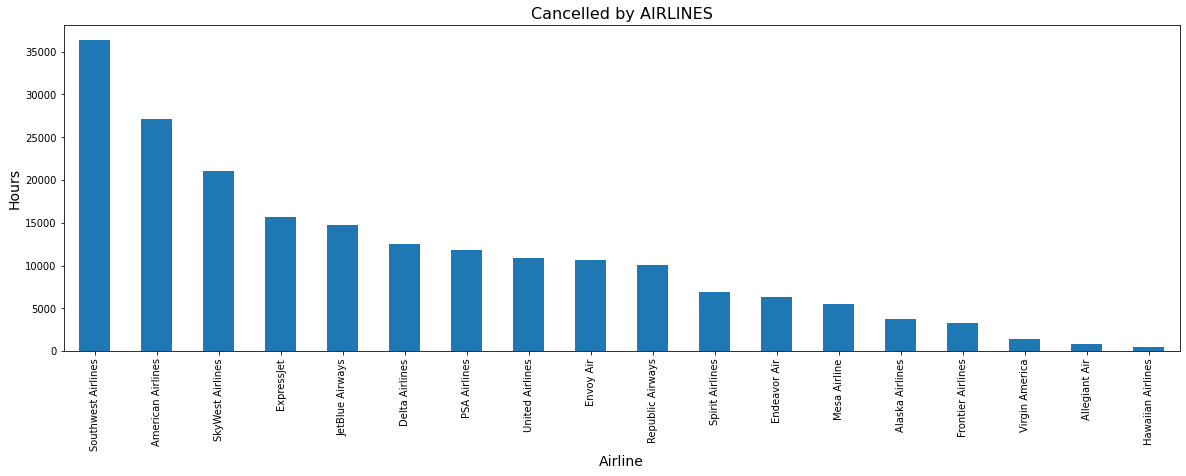

In [0]:
# Delays by airlines
plt.figure(figsize=(20, 6))
visualisation_df.groupby('OP_CARRIER').CANCELLED.sum().sort_values(ascending=False).plot.bar()
plt.title('Cancelled by AIRLINES', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Hours', fontsize=14)
plt.show()

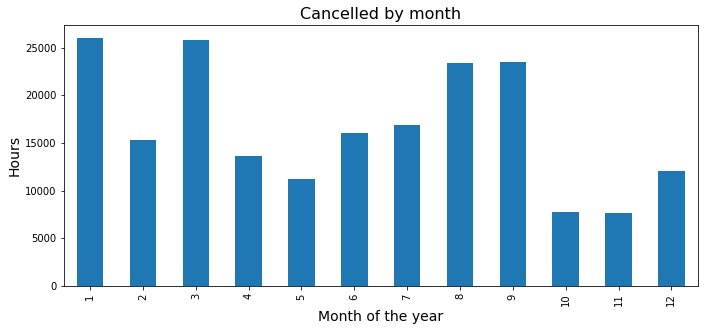

In [0]:
# Arrival and departure delays by month of the year
plt.figure(figsize=(25, 12)).subplots_adjust(hspace = 0.5)

plt.subplot(2, 2 ,1)
visualisation_df['FL_DATE_month'] = pd.to_datetime(visualisation_df['FL_DATE']).dt.month
visualisation_df.groupby('FL_DATE_month').CANCELLED.sum().plot.bar().set_title('ARRIVAL delays by month')
plt.title('Cancelled by month', fontsize=16)
plt.ylabel('Hours', fontsize=14)
plt.xlabel('Month of the year', fontsize=14)

plt.show()

In [0]:
#Remove columns indirectly indicating flight cancellation to prevent data leakage.
#These columns are null most of the cancelled flights.

flights_df = flights_df.drop("Unnamed: 27", 
                        "CARRIER_DELAY", 
                        "WEATHER_DELAY",
                        "NAS_DELAY",
                        "SECURITY_DELAY",
                        "LATE_AIRCRAFT_DELAY",
                        "CANCELLATION_CODE",
                        "DEP_TIME",
                        "DEP_DELAY",
                        "TAXI_OUT",
                        "WHEELS_OFF",
                        "WHEELS_ON",
                        "TAXI_IN",
                        "ARR_TIME",
                        "ARR_DELAY",
                        "ACTUAL_ELAPSED_TIME", 
                        "AIR_TIME")

In [0]:
#Converting string data to numeric
carrier_indexer = StringIndexer(inputCol="OP_CARRIER", outputCol="OP_CARRIER_IX")
origin_indexer = StringIndexer(inputCol="ORIGIN", outputCol="ORIGIN_IX")
dest_indexer = StringIndexer(inputCol="DEST", outputCol="DEST_IX")


#One hot Encoding categorical data
onehotencoder_carrier_vector = OneHotEncoder(inputCol="OP_CARRIER_IX", outputCol="OP_CARRIER_vec")
onehotencoder_origin_vector = OneHotEncoder(inputCol="ORIGIN_IX", outputCol="ORIGIN_vec")
onehotencoder_dest_vector = OneHotEncoder(inputCol="DEST_IX", outputCol="DEST_IX")


In [0]:
#Checking balance of the data
cancelled_count = flights_df.groupBy(F.col("CANCELLED")).count()
print(cancelled_count.show())

+---------+--------+
|CANCELLED|   count|
+---------+--------+
|      0.0|12688783|
|      1.0|  199267|
+---------+--------+

None


In [0]:
# select subsample of positive samples
not_cancelled_df = flights_df.where(F.col('CANCELLED') == 0).sample(fraction=0.5)
# select an equal amount of negative samples (number of neg samples == number of pos samples)
cancelled_df = flights_df.where(F.col('CANCELLED') == 0).orderBy(F.rand()).limit(not_cancelled_df.count())

print(cancelled_df.count())
print(not_cancelled_df.count())

union_df = not_cancelled_df.union(cancelled_df)


6347277


### Analysing Data

### Pipeline

In [0]:
# Pipelining the preprocessing stages defined above 
pipeline = Pipeline(stages=[carrier_indexer, origin_indexer, dest_indexer,
                            onehotencoder_carrier_vector, onehotencoder_origin_vector,
                            onehotencoder_dest_vector])

transformed_union_df = pipeline.fit(union_df).transform(classify_df)

### Model Evaluation